In [1]:
# load dataset
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')

# EDA
print('5 data teratas')
df.head()

print('cek info dataset')
print(df.info(), '\n')

print('cek missing values')
print(df.isnull().sum(), '\n')

5 data teratas
cek info dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None 

cek missing values
survived         0
pc

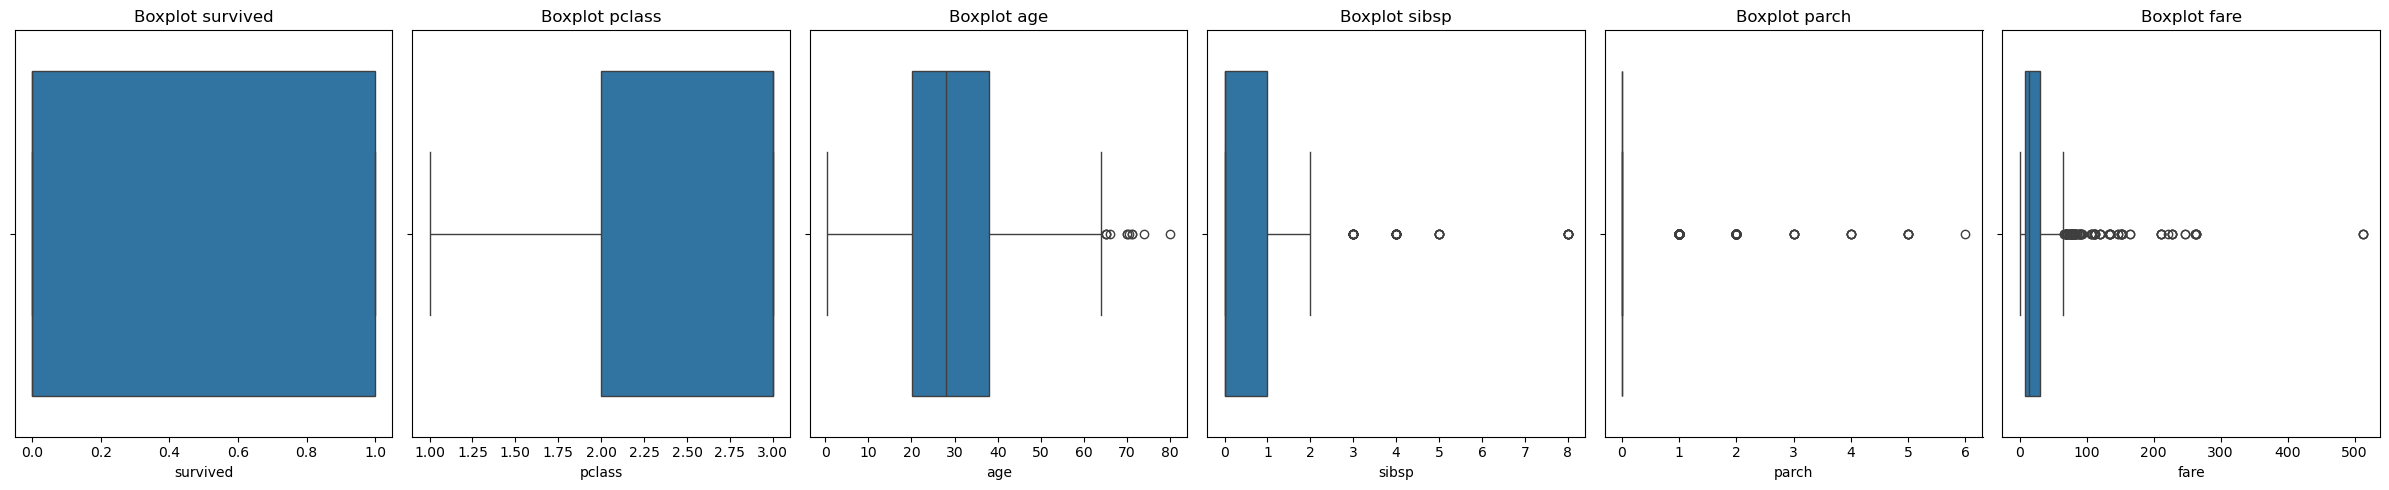

In [2]:
# cek outlier boxplot

import seaborn as sns
import matplotlib.pyplot as plt

# Ambil semua kolom numerik otomatis
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(len(numerical_cols) * 4, 5))  # Biar layout-nya rapi kalau banyak fitur

for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')

plt.tight_layout()
plt.show()


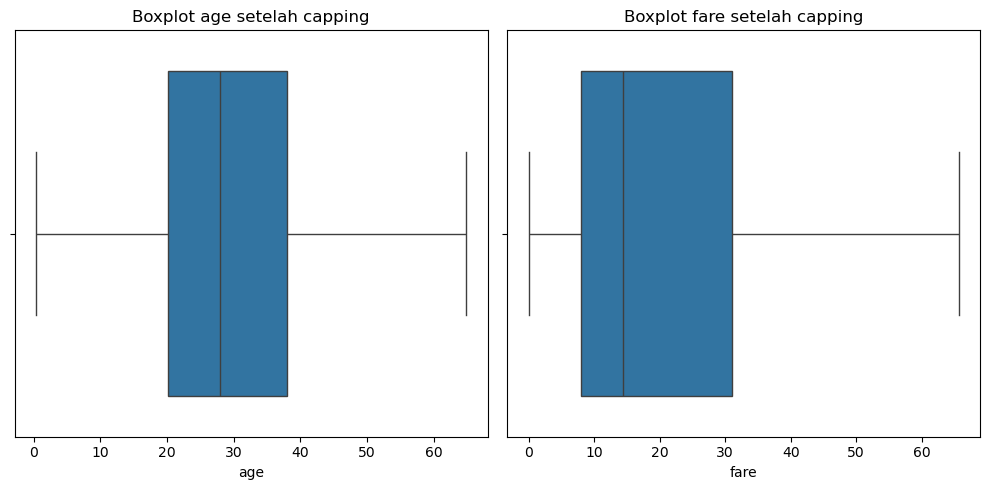

In [3]:
# handle outlier

# Capping outlier untuk kolom 'age'
Q1_age = df['age'].quantile(0.25)
Q3_age = df['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

df['age'] = df['age'].apply(lambda x: upper_bound_age if x > upper_bound_age else (lower_bound_age if x < lower_bound_age else x))

# Capping outlier untuk kolom 'fare'
Q1_fare = df['fare'].quantile(0.25)
Q3_fare = df['fare'].quantile(0.75)
IQR_fare = Q3_fare - Q1_fare

lower_bound_fare = Q1_fare - 1.5 * IQR_fare
upper_bound_fare = Q3_fare + 1.5 * IQR_fare

df['fare'] = df['fare'].apply(lambda x: upper_bound_fare if x > upper_bound_fare else (lower_bound_fare if x < lower_bound_fare else x))

# Cek boxplot setelah capping
plt.figure(figsize=(10, 5))
for i, col in enumerate(['age', 'fare']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col} setelah capping')

plt.tight_layout()
plt.show()


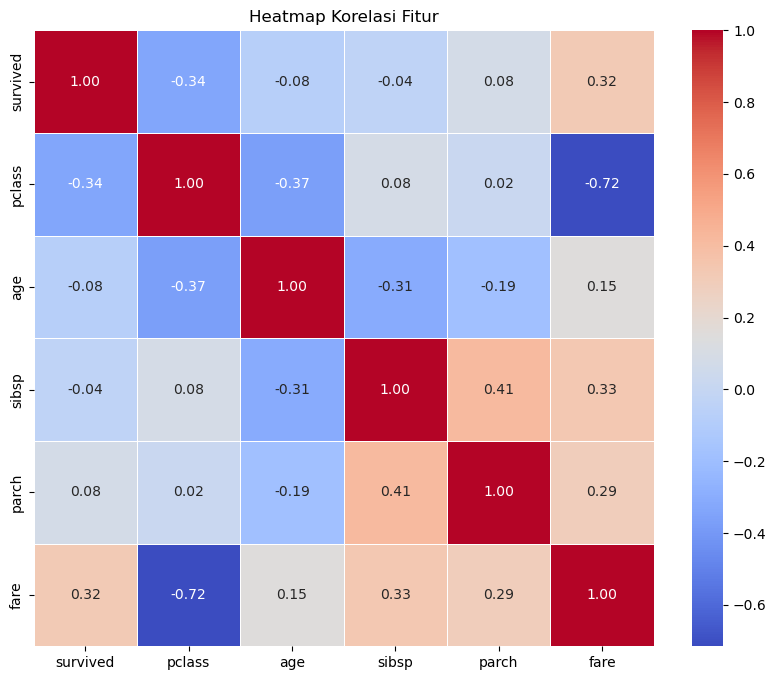

In [5]:
# Cek korelasi 1 

# Filter hanya kolom numerik 
df_numeric = df.select_dtypes(include=['number'])

# Cek korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Fitur')
plt.show()


In [6]:
# Cek tipe data tiap kolom
print(df.dtypes)

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


In [7]:
# preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Pisahkan fitur dan target
X = df.drop(columns=['survived', 'alive'])  # Drop 'alive' biar ga bocor ke model
y = df['survived']

# Bagi data jadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =======================
# Handle Missing Values
# =======================

# Handle missing values untuk kolom numerik 'age' dengan mean
X_train['age'] = X_train['age'].fillna(X_train['age'].mean())
X_test['age'] = X_test['age'].fillna(X_train['age'].mean())
#Kenapa X_test['age'] diisi pakai mean dari X_train['age']?
#Ini keputusan yang benar dalam preprocessing, karena data test itu seharusnya tetap diproses dengan informasi yang didapat dari data train. 
#Kalau kita pakai mean dari X_test, itu bisa dianggap "bocor" karena kita pakai informasi dari data yang seharusnya belum dilihat model. Jadi ini udah pas banget!

# Handle missing values untuk kolom kategorikal dengan modus
cat_cols = ['embarked', 'embark_town', 'deck']
for col in cat_cols:
    mode = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode)
    X_test[col] = X_test[col].fillna(mode)

# =======================
# Encoding Data Kategorikal
# =======================

# Label Encoding untuk kolom biner
label_cols = ['sex', 'who']
le = LabelEncoder()
for col in label_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# One-Hot Encoding untuk kolom kategorikal dengan banyak kategori
one_hot_cols = ['embarked', 'class', 'deck', 'embark_town']
X_train = pd.get_dummies(X_train, columns=one_hot_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=one_hot_cols, drop_first=True)

# Samakan kolom di X_train dan X_test biar gak ada mismatch
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# =======================
# Scaling Fitur Numerik
# =======================

num_cols = ['age', 'fare', 'sibsp', 'parch']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# =======================
# Hasil Akhir
# =======================

print("\nData training setelah preprocessing:\n", X_train.head())
print("\nData testing setelah preprocessing:\n", X_test.head())



Data training setelah preprocessing:
      pclass  sex       age     sibsp     parch      fare  who  adult_male  \
331       1    1  1.254960 -0.470722 -0.479342  0.224500    1        True   
733       2    1 -0.501902 -0.470722 -0.479342 -0.531688    1        True   
382       3    1  0.200843 -0.470722 -0.479342 -0.779279    1        True   
704       3    1 -0.267654  0.379923 -0.479342 -0.782733    1        True   
813       3    0 -1.829309  2.931860  2.048742  0.359882    0       False   

     alone  embarked_Q  ...  class_Second  class_Third  deck_B  deck_C  \
331   True       False  ...         False        False   False    True   
733   True       False  ...          True        False   False    True   
382   True       False  ...         False         True   False    True   
704  False       False  ...         False         True   False    True   
813  False       False  ...         False         True   False    True   

     deck_D  deck_E  deck_F  deck_G  embark_town_Quee

In [9]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest
model = RandomForestClassifier(
    n_estimators=10,  # Jumlah pohon dalam forest
)

# Training model dengan data training
model.fit(X_train, y_train)

# Memprediksi data testing
y_pred = model.predict(X_test)

# Evaluasi model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Akurasi Model:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Model: 0.7932960893854749

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       105
           1       0.78      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179


Confusion Matrix:
 [[91 14]
 [23 51]]


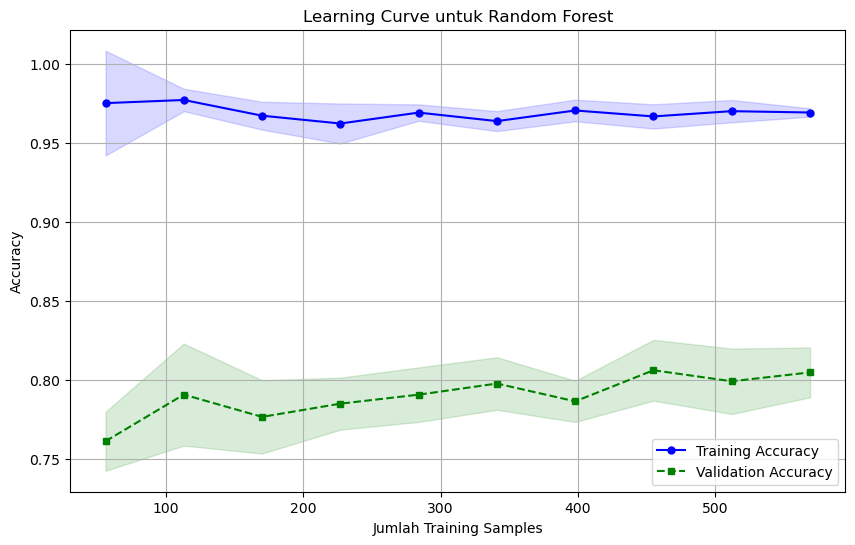

In [10]:
# learning_curve
# Import library yang diperlukan
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Membuat learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Menghitung mean dan std untuk plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Jumlah Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve untuk Random Forest')
plt.legend(loc='lower right')
plt.show()


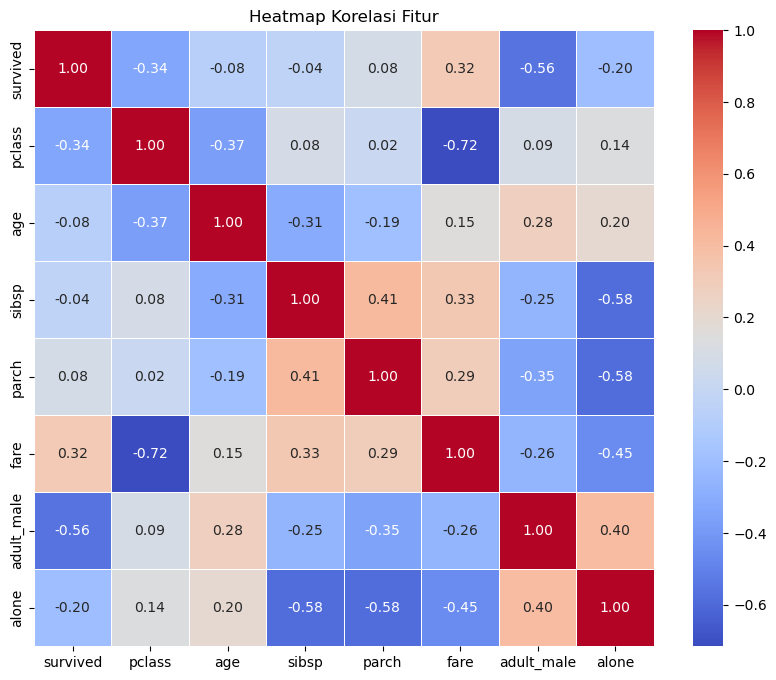

In [11]:
# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung matriks korelasi
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Fitur')
plt.show()

In [12]:
# Randomsearchcv

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report, confusion_matrix

model_randomsearch = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),  # Meningkatkan range jumlah pohon
    'max_depth': randint(10, 100),      # Meningkatkan kedalaman maksimal
    'min_samples_leaf': randint(1, 5),  # Mengurangi range untuk leaf samples
    'min_samples_split': randint(2, 10), # Memastikan minimal split lebih dari 1
    'max_features': ['sqrt', 'log2'],   # Menambahkan opsi feature selection
    'bootstrap': [True, False],         # Menambahkan opsi bootstrap
    'criterion': ['gini', 'entropy']    # Menambahkan opsi kriteria split
}


random_search = RandomizedSearchCV(model_randomsearch, param_distributions=param_dist, n_iter=20, random_state=42, scoring='accuracy')

random_search.fit(X_train, y_train)

best_rf_random = random_search.best_estimator_

y_pred_randomsearch = best_rf_random.predict(X_test)

print(f'Best params : {random_search.best_params_}')
print(f'best score : {random_search.best_score_}\n')
print(f'Classification Report : {classification_report(y_test, y_pred_randomsearch)}')
print(f'\nconfusion matrix :\n {confusion_matrix(y_test, y_pred_randomsearch)}')

Best params : {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 120}
best score : 0.8272431793558553

Classification Report :               precision    recall  f1-score   support

           0       0.84      0.90      0.87       105
           1       0.84      0.76      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179


confusion matrix :
 [[94 11]
 [18 56]]


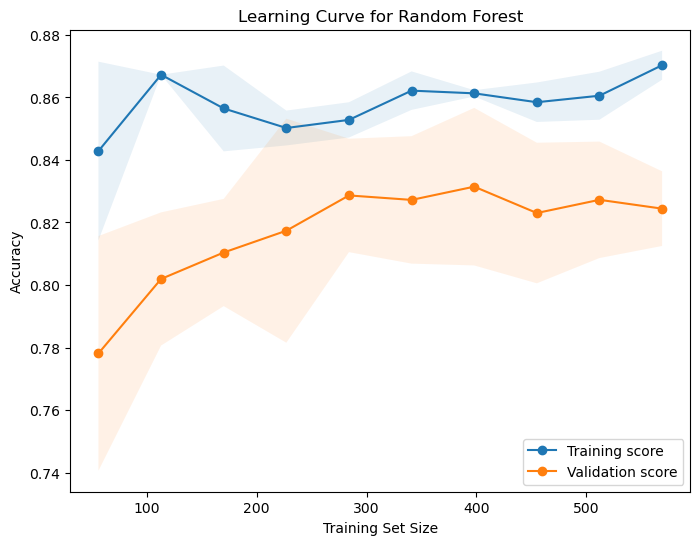

In [13]:
# learning curve untuk randomizedsearchcv

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Model Random Forest dengan parameter terbaik yang tadi
rf = RandomForestClassifier(
    bootstrap=True,
    criterion='entropy',
    max_depth=24,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=6,
    n_estimators=120,
    random_state=42
)

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    rf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Hitung mean dan std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation score', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve for Random Forest')
plt.show()